# LDA Approach

In this section, Latent Dirichlet Allocation is employed to elucidate the underlying topics associated with ABC's news headlines. An optimal topic selection procedure is proposed, utilizing the Coherence metric. Eight topics are meticulously chosen through a stratified sampling approach. Subsequently, the LDA procedure is executed for the entire dataset, and the progression of these eight topics per year is depicted.  

In [15]:
import pandas as pd
import numpy as np
import re
import string
import contractions
from nltk.stem import WordNetLemmatizer
from gensim import corpora
#from gensim.models import LdaModel
import  gensim.models.ldamodel
from gensim.models.coherencemodel import CoherenceModel

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Function to preprocess and tokenize a document
def preprocess_document(doc):
    # Get the default punctuation characters from the string module
    punctuation_pattern = f"[{re.escape(string.punctuation)}]"

    # Handle NA values
    doc = '' if pd.isnull(doc) else doc

    # Remove punctuation using the default pattern
    doc = re.sub(punctuation_pattern, '', doc)

    # Word tokenization using the contractions library
    doc = contractions.fix(doc)
    tokens = doc.split()
    
    #stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]


    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

The function preprocess_document executes the following preprocessing steps for each document: handling missing values, removing punctuation patterns, eliminating stop words, and ultimately employing a lemmatization approach.

### Sample per year

In [4]:
df = pd.read_csv('abcnews-date-text.csv')
df['year'] = df['publish_date'].astype(str).str[:4]
print(df.year.value_counts(1))
print(df.shape)

year
2013    0.073886
2012    0.071539
2014    0.065530
2008    0.064292
2011    0.062513
2015    0.062121
2007    0.062028
2009    0.061441
2010    0.060225
2005    0.058773
2004    0.058411
2006    0.053771
2003    0.051437
2016    0.049489
2017    0.038186
2020    0.032342
2018    0.032232
2019    0.027375
2021    0.014408
Name: proportion, dtype: float64
(1244184, 3)


Data regarding BBC headlines is loaded, encompassing approximately 1.2 million records spanning the years 2013 to 2021. The count of headlines per year exhibits a monotonically decreasing trend over time, with 2013 constituting 7% of observations and 2021 representing only 1.4%.

In [41]:
# work with the 10%
# Assuming 'year' is the column representing the year in your DataFrame
df_remaining, df_sample = train_test_split(df, test_size=0.3, random_state=42, stratify=df['year'])

Given the substantial size of our dataset comprising 1.2 million observations, performing optimal topic selection is computationally demanding. Therefore, we opt for a representative stratified sample (30%) to maintain the same proportion of headlines per year.

In [42]:
# Preprocess the sampled DataFrame
df_sample['processed_tokens'] = df_sample['headline_text'].apply(preprocess_document)
df_sample.head()

,publish_date,headline_text,year,processed_tokens
703524,20120621,fears housing affordability crisis brewing across,2012,"[fear, housing, affordability, crisis, brewing..."
272648,20061208,death casts dark shadow over asian games,2006,"[death, cast, dark, shadow, asian, game]"
8315,20030330,treatment may trigger diabetes inhibitions,2003,"[treatment, may, trigger, diabetes, inhibition]"
290132,20070307,damaged communications hamper sumatra rescue,2007,"[damaged, communication, hamper, sumatra, rescue]"
546629,20100626,ivory coast signs off with a win,2010,"[ivory, coast, sign, win]"


The preprocess_document function is applied to the sample dataframe

In [43]:
# Create Dictionary and Corpus for the sampled data
sampled_id2word = corpora.Dictionary(df_sample['processed_tokens'])
sampled_corpus = [sampled_id2word.doc2bow(text) for text in df_sample['processed_tokens']]


The code generates a dictionary (sampled_id2word) to establish mappings between words and integer IDs. Subsequently, a collection of documents (df_sample['processed_tokens']) is transformed into bag-of-words representations ( sampled_corpus) utilizing this dictionary.

In [84]:
# Build LDA model on the sampled data
lda_model = LdaModel(corpus=sampled_corpus, id2word=sampled_id2word, num_topics=4, random_state=100, update_every=1, 
                            chunksize=100, passes=10, alpha='auto', eta='auto', per_word_topics=True)

Based on the proposed sample, an initial LDA trial is conducted with four topics. The alpha parameter specifies the hyperparameter for the Dirichlet prior on the per-document topic distributions. Setting it to 'auto' enables the model to learn an asymmetric prior from the data. The 'eta' parameter represents the a priori belief on the topic-word distribution; when set to 'auto,' it learns an asymmetric prior from the corpus. A chunk size of 100 is considered, indicating the number of documents to be processed in each training chunk. Larger chunk sizes may accelerate training but could need more memory.

Setting passes to 10 implies the number of passes over the entire corpus during training. While more passes can enhance topic models, they may also extend training time. If per_word_topics is set to True, the model will compute a list of topics to which each word belongs, along with their respective probabilities.

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[sampled_corpus]

[(0,
  '0.009*"plan" + 0.009*"win" + 0.009*"hospital" + 0.008*"australia" + '
  '0.008*"face" + 0.007*"claim" + 0.006*"qld" + 0.006*"set" + 0.006*"child" + '
  '0.006*"school"'),
 (1,
  '0.022*"police" + 0.016*"new" + 0.010*"council" + 0.009*"australian" + '
  '0.009*"fire" + 0.007*"court" + 0.007*"water" + 0.006*"seek" + 0.006*"crash" '
  '+ 0.006*"woman"'),
 (2,
  '0.016*"man" + 0.011*"death" + 0.011*"call" + 0.011*"govt" + 0.010*"u" + '
  '0.008*"help" + 0.007*"health" + 0.007*"dog" + 0.007*"national" + '
  '0.007*"government"'),
 (3,
  '0.018*"say" + 0.012*"interview" + 0.011*"back" + 0.010*"murder" + '
  '0.009*"first" + 0.008*"report" + 0.007*"sydney" + 0.007*"get" + 0.007*"nsw" '
  '+ 0.006*"rural"')]


lda_model.print_topics() yields the top 10 keywords that contribute to each topic, accompanied by their respective weights relative to that topic. These weights means the significance of each keyword within the context of the given topic.

In [24]:
# Plotting tools
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, sampled_corpus, sampled_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.238303 -0.039372       1        1  26.253853
2     -0.135081 -0.187743       2        1  26.133764
0     -0.075457  0.202806       3        1  24.933204
3     -0.027765  0.024309       4        1  22.679179, topic_info=           Term        Freq       Total Category  logprob  loglift
153      police  387.000000  387.000000  Default  30.0000  30.0000
227         say  273.000000  273.000000  Default  29.0000  29.0000
396         new  280.000000  280.000000  Default  28.0000  28.0000
108         man  274.000000  274.000000  Default  27.0000  27.0000
622       death  202.000000  202.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1927  president   56.497563   57.233770   Topic4  -5.6006   1.4708
234    brisbane   54.343880   55.057609   Topic4  -5.6394   1.4707
58      liberal   51.194972   51.911962   Topic4  -5.6991   1.4698
770       share   51.393041   52.113606   Topic4  -5.6952   1.4698
499      denies   50.219400   50.932804   Topic4  -5.7184   1.4696

[151 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
192       3  0.987924     accused
106       2  0.994705      attack
311       3  0.992927   australia
438       1  0.995533  australian
280       4  0.992954        back
...     ...       ...         ...
314       3  0.992457         win
34        1  0.998260       woman
1108      2  0.995924      worker
996       1  0.989729       world
110       2  0.990772        year

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## Optimal LDA Topics

In [49]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective numbers of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = gensim.models.ldamulticore.LdaMulticore(workers=6, 
                                                        corpus=corpus, 
                                                        id2word=dictionary, 
                                                        num_topics=num_topics, 
                                                        random_state=100, 
                                                        chunksize=100, 
                                                        passes=5, 
                                                         alpha='symmetric', 
                                                         eta='auto'
                                                        per_word_topics=True)
 
 #       model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        model_list.append(model)
        
        # Compute Coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


The function compute_coherence_values is intended to calculate the coherence obtained when an LDA model is executed for various numbers of topics. The coherence measure facilitates the differentiation between effective and ineffective topics by evaluating the degree of semantic similarity among highly scored words within a topic.
In this case, the use of LdaMulticore is preferred, as it leverages all available CPU cores to parallelize and expedite the model training process.

In [51]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=sampled_id2word, corpus=sampled_corpus, texts=df_sample['processed_tokens'], start=2, limit=40, step=3)


The function compute_coherence_values return two list: The LDA models and their coherence value.

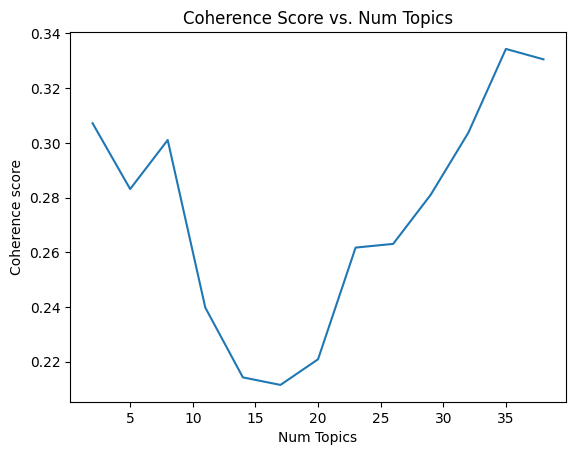

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have coherence_values and x defined
limit = 40
start = 2
step = 3
x = range(start, limit, step)

# Plot using seaborn
sns.lineplot(x=x, y=coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Num Topics")
plt.show()

An elbow approach is employed to determine the optimal number of topics based on coherence. The goal is to identify a value of "k" that  marks the end of a rapid growth of topic coherence. Typically, this chosen number of topics yields meaningful and interpretable topics. Opting for a higher value might occasionally provide more nuanced sub-topics.

Ideally, a graph exhibiting an elbow with increasing monotonic characteristics is anticipated, as a higher "k" should lead to improved coherence. However, somewhat unexpectedly, the coherence metric begins to decline between k=11 and k=17. Subsequently, it initiates an ascent, reaching its peak at k=33. Nevertheless, for simplicity, we opt for 8 topics, presuming that this selection aligns more closely with subtopics, especially in the context of news analysis.

In [67]:

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
num_topics=8

Num Topics = 2  has Coherence Value of 0.3072
Num Topics = 5  has Coherence Value of 0.2831
Num Topics = 8  has Coherence Value of 0.301
Num Topics = 11  has Coherence Value of 0.2398
Num Topics = 14  has Coherence Value of 0.2143
Num Topics = 17  has Coherence Value of 0.2115
Num Topics = 20  has Coherence Value of 0.2209
Num Topics = 23  has Coherence Value of 0.2617
Num Topics = 26  has Coherence Value of 0.2631
Num Topics = 29  has Coherence Value of 0.2811
Num Topics = 32  has Coherence Value of 0.3037
Num Topics = 35  has Coherence Value of 0.3344
Num Topics = 38  has Coherence Value of 0.3305


These are the coherence values portrayed in the previous image

Optimal number of topic 8

In [70]:
# running LDA with 8 topics in sample dataset
lda_model = gensim.models.ldamulticore.LdaMulticore(workers=6, corpus=sampled_corpus, id2word=sampled_id2word, num_topics=8, random_state=100, chunksize=100, passes=10, per_word_topics=True)
#lda_model = LdaModel(corpus=sampled_corpus, id2word=sampled_id2word, num_topics=11, random_state=100, update_every=1, 
#                            chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, sampled_corpus, sampled_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.226793 -0.030650       1        1  14.576688
2      0.257296 -0.075227       2        1  13.684357
3      0.087069  0.115750       3        1  12.920950
7     -0.226762  0.043345       4        1  12.885459
1      0.119832  0.134949       5        1  11.764054
4      0.106735  0.158229       6        1  11.683345
5     -0.158567  0.033222       7        1  11.619950
0      0.041190 -0.379617       8        1  10.865196, topic_info=           Term          Freq         Total Category  logprob  loglift
174         man   9828.000000   9828.000000  Default  30.0000  30.0000
278       court   5711.000000   5711.000000  Default  29.0000  29.0000
200      police  12111.000000  12111.000000  Default  28.0000  28.0000
459   interview   5060.000000   5060.000000  Default  27.0000  27.0000
25          win   5075.000000   5075.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1519        abc   1241.668636   2304.101449   Topic8  -5.1775   1.6014
2823    weather    846.090796   1241.105825   Topic8  -5.5611   1.8365
1236   canberra    899.048307   2033.091398   Topic8  -5.5004   1.4036
445     council    941.405338   5775.109094   Topic8  -5.4544   0.4057
9         death    866.387655   4748.156308   Topic8  -5.5374   0.5184

[370 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
894       3  0.999004      19
2640      4  0.998826  abbott
1519      3  0.194436     abc
1519      7  0.266481     abc
1519      8  0.539039     abc
...     ...       ...     ...
145       2  0.284675    year
145       3  0.360276    year
145       5  0.169179    year
145       7  0.098750    year
145       8  0.086929    year

[483 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 8, 2, 5, 6, 1])

## Run LDA in the whole dataset

Once we know the optimal number of topics to be selected, we run the LDA model in the whole dataset.

In [57]:
print(df.shape)
df.head()

(1244184, 3)


,publish_date,headline_text,year
0,20030219,aba decides against community broadcasting lic...,2003
1,20030219,act fire witnesses must be aware of defamation,2003
2,20030219,a g calls for infrastructure protection summit,2003
3,20030219,air nz staff in aust strike for pay rise,2003
4,20030219,air nz strike to affect australian travellers,2003


The full dataset

In [61]:
# Infer topics on the full dataset using the existing LDA model
df['processed_tokens'] = df['headline_text'].apply(preprocess_document)

id2word_full = corpora.Dictionary(df['processed_tokens'])
corpus_full = [id2word_full.doc2bow(text) for text in df['processed_tokens']]

The same preposecion steps are done for the entire dataset

In [73]:
lda_model = gensim.models.ldamulticore.LdaMulticore(workers=6, 
                                                    corpus=corpus_full,
                                                    id2word=id2word_full, 
                                                    num_topics=8,
                                                    random_state=100,
                                                    chunksize=100,
                                                    passes=10, 
                                                    alpha='symmetric', 
                                                    eta='auto',
                                                    per_word_topics=True)


The LDA model is definer for 8 topics

In [75]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_full, id2word_full)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.292759  0.000588       1        1  14.396411
0      0.075719 -0.260367       2        1  13.675276
4      0.150912 -0.101284       3        1  13.372666
7      0.205179 -0.037222       4        1  12.758208
1      0.123736  0.328091       5        1  12.110966
2      0.089537  0.075735       6        1  11.857802
3     -0.156836 -0.146211       7        1  11.319055
5     -0.195488  0.140672       8        1  10.509617, topic_info=              Term          Freq         Total Category  logprob  loglift
92535  coronavirus  62769.000000  62769.000000  Default  30.0000  30.0000
92753        covid  36552.000000  36552.000000  Default  29.0000  29.0000
48       australia  42912.000000  42912.000000  Default  28.0000  28.0000
2601    queensland  24227.000000  24227.000000  Default  27.0000  27.0000
10527        trump  22755.000000  22755.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1380          year   5356.222631  19591.923491   Topic8  -4.8861   0.9560
99          attack   4341.301163   9871.629900   Topic8  -5.0962   1.4314
769           dead   3943.781408   6820.591499   Topic8  -5.1922   1.7051
77           state   3787.212675  11318.197267   Topic8  -5.2327   1.1581
1271          road   3669.721384   5761.435911   Topic8  -5.2642   1.8018

[343 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3499       4  0.999960        19
15431      1  0.999863      2020
6273       1  0.999955       abc
2448       6  0.999836     abuse
1214       2  0.999906  adelaide
...      ...       ...       ...
1380       6  0.119386      year
1380       7  0.161852      year
1380       8  0.273378      year
426        1  0.999757     young
455        1  0.999729   zealand

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 8, 2, 3, 4, 6])

## Topic evolution over time

In [74]:
# Perform inference on the full dataset
topic_distributions_full, _ = lda_model.inference(corpus_full)
df['dominant_topic'] = [np.argmax(topic_dist) for topic_dist in topic_distributions_full]

topic_distributions_full is a matrix wherein each row corresponds to a document, and each column corresponds to a topic. The values in this matrix denote the probability distribution of topics for each document. Subsequently, the dominant topic for each document is assigned in the dataframe, determined by the highest probability within the document's probability distribution across the topics in topic_distributions_full.

In [77]:
from gensim import models
from operator import itemgetter

# Assuming lda_model_full is your trained LDA model on the full dataset
# You may need to adjust the num_topics variable based on the actual number of topics you used
num_topics = 8

# Get the top 10 words for each topic
topic_names = []
for topic_id in range(num_topics):
    # Get the top 10 words for the current topic
    top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    topic_names.append(top_words)

# Print the extracted top words for each topic
for i, top_words in enumerate(topic_names):
    print(f"Topic {i} Top Words: {', '.join(top_words)}")


Topic 0 Top Words: coronavirus, nsw, adelaide, minister, restriction, plan, say, wa, community, change
Topic 1 Top Words: australia, sydney, day, world, market, found, tasmania, one, home, first
Topic 2 Top Words: victoria, government, family, australia, health, new, rise, test, andrew, could
Topic 3 Top Words: coronavirus, case, china, police, people, new, perth, afl, life, care
Topic 4 Top Words: coast, national, border, school, federal, morrison, gold, new, royal, australian
Topic 5 Top Words: queensland, two, victorian, scott, victim, police, year, south, assault, second
Topic 6 Top Words: man, woman, melbourne, donald, news, child, court, police, vaccine, car
Topic 7 Top Words: covid, trump, 19, u, election, australian, say, north, west, interview


This code retunr the top 10 most important words per topic

In [82]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda1 = lda_model[corpus_full]

[(0,
  '0.028*"coronavirus" + 0.012*"nsw" + 0.012*"adelaide" + 0.011*"minister" + '
  '0.011*"restriction" + 0.010*"plan" + 0.010*"say" + 0.009*"wa" + '
  '0.009*"community" + 0.009*"change"'),
 (1,
  '0.039*"australia" + 0.026*"sydney" + 0.018*"day" + 0.016*"world" + '
  '0.013*"market" + 0.012*"found" + 0.012*"tasmania" + 0.011*"one" + '
  '0.011*"home" + 0.011*"first"'),
 (2,
  '0.023*"victoria" + 0.023*"government" + 0.014*"family" + 0.014*"australia" '
  '+ 0.010*"health" + 0.009*"new" + 0.008*"rise" + 0.008*"test" + '
  '0.008*"andrew" + 0.008*"could"'),
 (3,
  '0.049*"coronavirus" + 0.025*"case" + 0.018*"china" + 0.017*"police" + '
  '0.012*"people" + 0.012*"new" + 0.011*"perth" + 0.010*"afl" + 0.009*"life" + '
  '0.008*"care"'),
 (4,
  '0.013*"coast" + 0.012*"national" + 0.011*"border" + 0.010*"school" + '
  '0.010*"federal" + 0.009*"morrison" + 0.008*"gold" + 0.008*"new" + '
  '0.008*"royal" + 0.008*"australian"'),
 (5,
  '0.034*"queensland" + 0.017*"two" + 0.012*"victorian" +

This code returns the top 10 most important words per topic and their respective weights on each topic.

In [78]:
# Assuming you have a list of manually inputted topic names
manual_topic_names = ["Topic_A", "Topic_B", "Topic_C", "Topic_D", "Topic_E", "Topic_F", "Topic_G", "Topic_H"]

# Assuming df_sample is your DataFrame with the 'dominant_topic' column
# Assign the topic names to the 'topic_name' column in the DataFrame
df['topic_name'] = df['dominant_topic'].map(lambda x: manual_topic_names[x])


This code allows to define a particular name per each topic.

In [80]:
df.head()

,publish_date,headline_text,year,processed_tokens,dominant_topic,topic_name
0,20030219,aba decides against community broadcasting lic...,2003,"[aba, decides, community, broadcasting, licence]",7,Topic_H
1,20030219,act fire witnesses must be aware of defamation,2003,"[act, fire, witness, must, aware, defamation]",3,Topic_D
2,20030219,a g calls for infrastructure protection summit,2003,"[g, call, infrastructure, protection, summit]",7,Topic_H
3,20030219,air nz staff in aust strike for pay rise,2003,"[air, nz, staff, aust, strike, pay, rise]",2,Topic_C
4,20030219,air nz strike to affect australian travellers,2003,"[air, nz, strike, affect, australian, traveller]",7,Topic_H


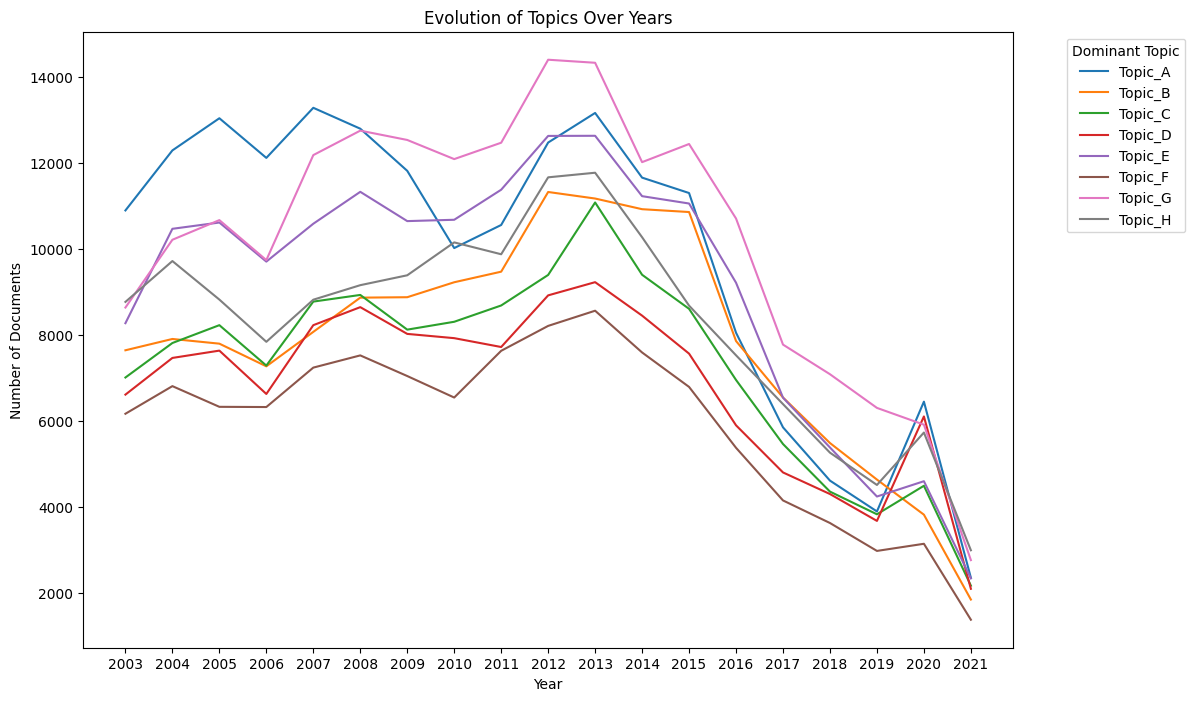

In [81]:
# Assuming df_sample is your DataFrame with the 'topic_name' and 'year' columns

# Group by 'year' and 'topic_name' and calculate the count
topic_counts = df.groupby(['year', 'topic_name']).size().reset_index(name='count')

# Plot the evolution of topics over years using seaborn lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=topic_counts, x='year', y='count', hue='topic_name')
plt.title("Evolution of Topics Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Documents")
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The graph illustrates the temporal evolution of the 8 topics. Notably, Topic G (or 7) exhibits a substantial increase from 2003, reaching its peak in 2012. However, all topics begin to decline thereafter, a trend attributed to the decreasing number of headlines in the dataframe, as previously mentioned.

The top 10 words associated with Topic G are: man, woman, Melbourne, Donald, news, child, court, police, vaccine, car

### Reference

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
https://github.com/Federicosoldati/Text-Mining-Group-3-Project-1/blob/main/Project1.ipynb
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Evaluate%20Topic%20Models.ipynb
https://datascience.oneoffcoder.com/topic-modeling-gensim.html
https://bennett-holiday.medium.com/a-step-by-step-guide-to-writing-an-lda-program-in-python-690aa99119ea
https://medium.com/@patrickhk/build-a-lda-model-for-classification-with-gensim-80ca6343c4b9
https://medium.com/@rudyb2001/making-sense-of-the-news-using-machine-learning-e13ed5f96cf0

